In [1]:
import jax
import numpy as onp
import jax.numpy as np
from jax import jit, vmap
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as t
from ipywidgets import interact
from jax import grad
from jax.scipy.optimize import minimize
from jax.config import config
config.update("jax_enable_x64", True)
from jax.scipy.linalg import cho_factor, cho_solve
from functools import reduce
#from jax.scipy.optimize import minimize
#from jaxopt import ProjectedGradient
#from jaxopt.projection import projection_box

\begin{equation}\label{eqehyehdyd}
\begin{split}
\frac{d[H_2]}{dt}&=-k_1[H_2]+k_{-1}[H]^2\\
\frac{d[H]}{dt}&=2k_1[H_2]-2k_{-1}[H]^2-k_2 [C_2H_4][H]-k_3[C_2H_5][H]\\
\frac{d[C_2H_4]}{dt}&=-k_2 [C_2H_4][H]\\
\frac{d[C_2H_5]}{dt}&=k_2 [C_2H_4][H]-k_3[C_2H_5][H]
\end{split}
\end{equation}

In [2]:
#From now on, we order them as (H2, H, C2H4, C2H5, then the derivatives)
#Simulate data

In [3]:
from scipy.integrate import solve_ivp

def F(t, X): #all k = 1
    H_2, H, C2H4, C2H5 = X
    u = - H_2 + H**2
    d = 2*H_2 - 2*H**2 - C2H4*H - C2H5*H 
    t = -C2H4*H
    q = C2H4*H - C2H5*H
    return u, d, t, q
def build_dataset(n_init_cond = 50, t_f = 5, n_times_per_cond = 50):
    l = onp.zeros((n_init_cond*n_times_per_cond,8))
    for i in range(n_init_cond):
        sol = solve_ivp(F,(0,t_f), onp.random.random(size = 4), t_eval = np.linspace(0,t_f,n_times_per_cond))
        derivatives = [F(None, i) for i in sol.y.T]
        l[i*n_times_per_cond:(i+1)*n_times_per_cond] = np.hstack((sol.y.T, derivatives))
    return l

#t_f = 5
#n_times_per_cond = 50
#sol = solve_ivp(F,(0,t_f), onp.random.random(size = 4), t_eval = np.linspace(0,t_f,n_times_per_cond))

l = build_dataset()

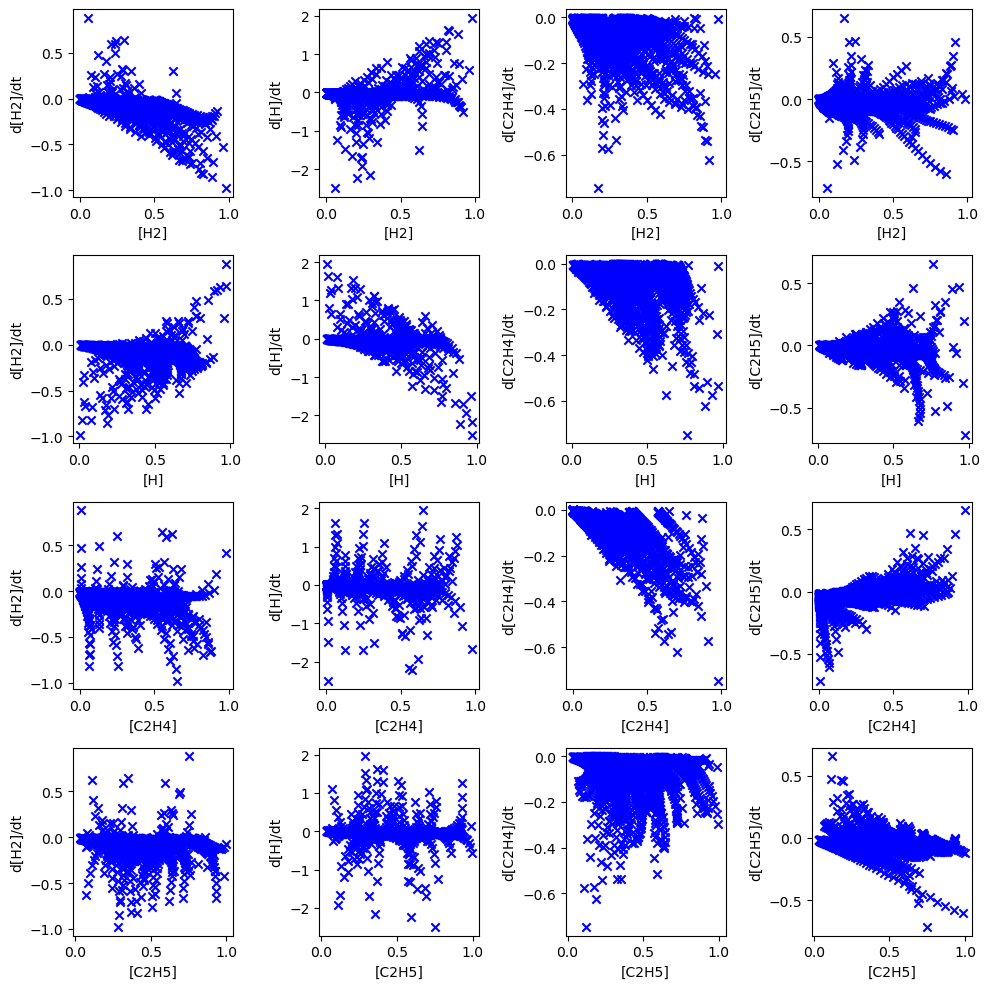

In [4]:
names = ['[H2]', '[H]', '[C2H4]', '[C2H5]']
dnames = ['d'+i+'/dt' for i in names]
fig, ax = plt.subplots(4, 4)
fig.set_size_inches(10,10)
fig.set_dpi(100)
for idx in range(50):
    for i in range(4):
        for j in range(4):
            ax[i,j].set_xlabel(names[i])
            ax[i,j].set_ylabel(dnames[j])
            ax[i,j].scatter(l[50*idx:50*(idx+1),i], l[50*idx:50*(idx+1),j+4], c = 'blue', marker = 'x')
plt.tight_layout()


In [5]:
#The graph we want to build here is bipartite: 
#We want to discover which of the derivatives are a function of which nonderivatives

In [6]:
possible_edges = [] #directed: (1, 2) means there could be a function mapping 1 to 2
#In this case (i -> j) for all i in [0, 3] and all j in [4, 7]
for i in range(4):
    for j in range(4, 8):
        possible_edges.append([i,j])

In [7]:
names = names + dnames

In [8]:
X = l.T

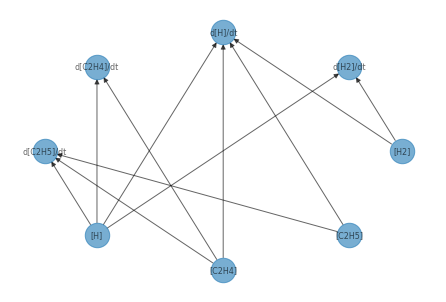

In [9]:
from graph_discovery import build_graph
from kernels import kpoly
ks = [kpoly]*8

build_graph(X, ks, possible_edges=possible_edges, γ2 = 0.47, nugget=1e-6, names = names, plot = True)

In [24]:
#There is a lot of sensitivity wrt γ2, but with the right value one recovers the right graph

In [25]:
#What if we don't impose possible edges?

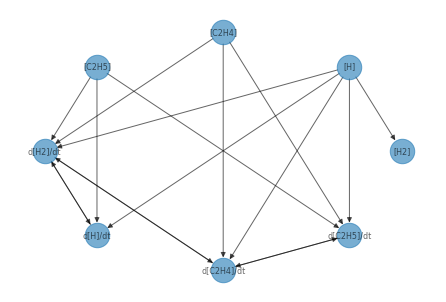

In [30]:
build_graph(X, ks, γ2 = 0.45, nugget=1e-6, names = names, plot = True)